In [171]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [172]:
def uniformQuantization(I):
    '''
    Quantizes the image to 10 levels
    Returns quantized image
    '''
    step = 255/10
    partitions = np.arange(step,255,step)
    codebook = np.arange(10)*step
    
    I[I<= partitions[0]] = codebook[0]
    for i in range(partitions.shape[0]-1):
        I[np.logical_and(I>partitions[i], I<=partitions[i+1])] = codebook[i+1]
    I[I>partitions[-1]] = codebook[-1]
    
    return I

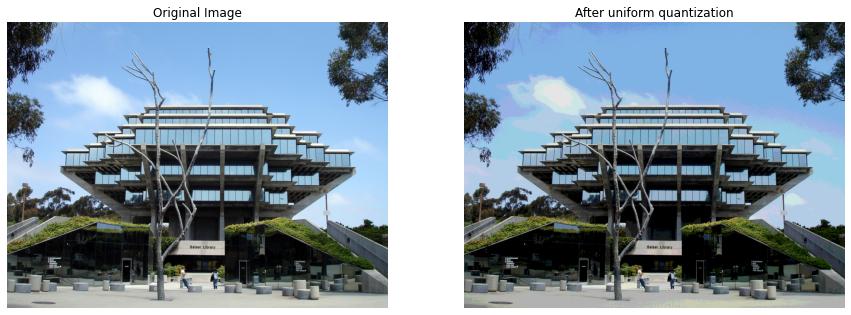

In [173]:
I = cv2.imread('geisel.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
#I = cv2.imread('diver.tif')
#I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(I)

I_uq = uniformQuantization(np.copy(I))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('After uniform quantization')
plt.imshow(I_uq)

Original image and quantized image

In [174]:
def find_closest_palette_color(pixel):
    step = 255/10
    pixel_q = np.floor(np.copy(pixel)/step)*step
    return pixel_q

In [175]:
def clip(pixel):
    return np.where(pixel>255,255,pixel)

In [176]:
def FSD(I):
    '''
    Implements the Floyd Steinberg Dithering algorithm
    '''
    I_pad = np.pad(I, [(1, 1), (1, 1), (0,0)], mode='constant', constant_values=0)
    I_pad = I_pad.astype('float')
    for j in range(1,I_pad.shape[1]-1):
        for i in range(1,I_pad.shape[0]-1):
            old_pixel = np.copy(I_pad[i,j,:])
            new_pixel = find_closest_palette_color(I_pad[i,j,:])
            I_pad[i,j,:] = new_pixel
            qError = old_pixel - new_pixel
            I_pad[i+1,j,:] = clip(I_pad[i+1,j,:] + qError * 7 / 16)
            I_pad[i-1,j+1,:] = clip(I_pad[i-1,j+1,:] + qError * 3 / 16)
            I_pad[i,j+1,:] = clip(I_pad[i,j+1,:] + qError * 5 / 16)
            I_pad[i+1,j+1,:] = clip(I_pad[i+1,j+1,:] + qError * 1 / 16)
    I_pad = I_pad[1:-2,1:-2,:]
    return I_pad.astype(np.uint8)

In [177]:
I_dither = FSD(I)

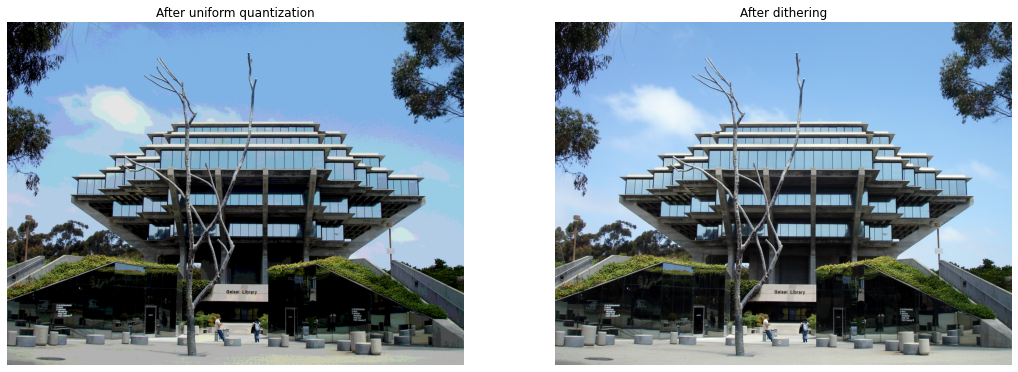

In [190]:
plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('After uniform quantization')
plt.imshow(I_uq)

plt.subplot(1,2,2)
plt.axis('off')
plt.title('After dithering')
plt.imshow(I_dither)

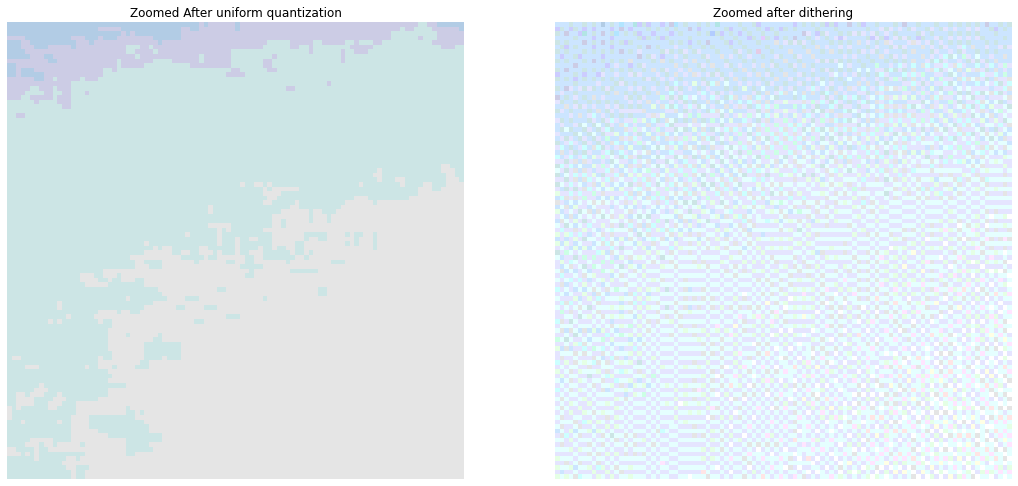

In [195]:
l = I_dither.shape[0]
b = I_dither.shape[1]
n = 100
k = 0.2
I_dither_zoomed = I_dither[int(k*l):int(k*l + n),int(k*b):int(k*b+n),:]
I_uq_zoomed = I_uq[int(k*l):int(k*l + n),int(k*b):int(k*b+n),:]

plt.figure(figsize=(18,18))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('Zoomed After uniform quantization')
plt.imshow(I_uq_zoomed)

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Zoomed after dithering')
plt.imshow(I_dither_zoomed)

1)\
The resultant image after 10 level- quantization has a number of artifacts. We can especially observe this in the sky that the edges and border of the cloud gets lost. However, upon Floyd Steinberg Dithering, the resultant image looks almost similar to the orginal image.

2)\
The quantized image has artifacts because of the quantization error introduced. This is eliminated in case od the dithered image. This is because by introducing a psuedo structured noise in the image we are trying to elminate the quantization error or distribute it in a smart way in order to make the quantized image look similar visually. More specifically, the algorithm is trying to push the quantization error of the current pixels to its neighbours that have not been visited yet. By doing so some pixels have a positive quantization error while other have a negative quantization error, which in total is summing to zero. 